# Blackbox NN for Query-52

    Datasize  IdleTimeout  BacklogTimeout  ExecutionTime
0         20            5              15             50
1         20           20               8             47
2         20            7               8             56
3         20           16               8             56
4         20           13              14             47
5         20           10               7             59
6         20            4              12             62
7         20           35              30             43
8         20            3               8             60
9         20           10               6             62
10       100            5              15             57
11       100           20               8             48
12       100            7               8             60
13       100           16               8             47
14       100           13              14             42
15       100           10               7             43
16       100            4      

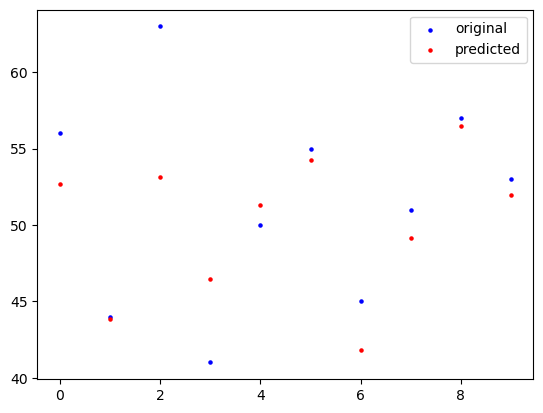

In [1]:
# This notebook is based on the methodology described in:
# Tariq, H., & Das, O. (2023). Execution Time Prediction Model that Considers Dynamic Allocation of Spark Executors.
# In: Gilly, K., Thomas, N. (eds) Computer Performance Engineering. EPEW 2023. LNCS, vol 14231. Springer, Cham.
# DOI: https://doi.org/10.1007/978-3-031-43185-2_23

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import os, sys
import pandas as pd
import numpy as np


# In[2]:


train = pd.read_csv('query52train.csv')
print(train)


# In[3]:


import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.utils import shuffle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

#training set and test set
train_set=train[train[['Datasize']].isin([20, 100, 200]).any(axis=1)]
test_set=train[train[['Datasize']].isin([500]).any(axis=1)]

print("TRAIN SET", train_set)
print("TEST SET", test_set)

#shuffle
#shuffle_train = shuffle(train_set)
#shuffle_test = shuffle(test_set)

#train set: x,y split
x_train_set = train_set[['Datasize', 'IdleTimeout', 'BacklogTimeout']]
y_train_set = train_set['ExecutionTime']


#test set: x,y split
x_test_set = test_set[['Datasize', 'IdleTimeout', 'BacklogTimeout']]
y_test_set = test_set['ExecutionTime']

print ("\ntrain/test split lengths ", len(x_train_set),len(x_test_set),len(y_train_set),len(y_test_set))

#normalizing training input data 
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(x_train_set)
test_x_scaled = scaler.fit_transform(x_test_set)

#split training data for validation 
#x_train, x_val, y_train, y_val = train_test_split(train_x_scaled, y_train_set, test_size=0.33) #random_state=100)
#print ("\nvalidation split lengths", len(x_train),len(x_val),len(y_train),len(y_val))

#5-fold
kfold = KFold(n_splits=5, shuffle=True)

#regressor parameters 
mlp = MLPRegressor(hidden_layer_sizes=(25,25), max_iter=10000, alpha= 0.001, 
                   solver= 'adam', activation='relu', batch_size= 1, 
                   learning_rate= 'adaptive', learning_rate_init= 0.01, 
                   beta_1= 0.9)

#fit training data 
training = mlp.fit(train_x_scaled, y_train_set)
print("\nconfiguration: ", training)

#cross validation on training set
results = cross_val_score(mlp, train_x_scaled, y_train_set, cv=kfold) 

#prediction
y_pred = mlp.predict(test_x_scaled)

actual = np.array(y_test_set)
pred = np.array(y_pred)

print ("\nprediction: ", pred) #array_output
print ("\nactual: ", actual)

mape = np.mean(np.abs((actual - pred)/actual)) * 100

print("mape = ", mape)
print("built-in function mape: ", mean_absolute_percentage_error(actual, pred))


# In[4]:


import matplotlib.pyplot as plt

x_ax = range(len(y_test_set))
plt.scatter(x_ax, y_test_set, s=5, color="blue", label="original")
plt.scatter(x_ax, pred, s=5, color="red", label="predicted")
plt.legend()
plt.show()


# In[ ]: